# Assignment - Machine Learning Inference on the NPU with Pytorch and ONNX


## Goals

* Demonstrate Ryzen SW flow for inference on NPU with pre-trained model

* Learn Ryzen AI Software APIs
    

## Problem

* Explore a trained model that classifies grayscale images of clothing items in the fashion-mnist dataset
  
* Use NPU to inference new images unseen during training process and classify per clothing item class

      
## References

**[Ryzen AI SW repo](https://github.com/amd/RyzenAI-SW/tree/main/tutorial)**

**[Ryzen AI Software Platform](https://ryzenai.docs.amd.com/en/latest/getstartex.html)**

**[Vitis AI Execution Provider](https://onnxruntime.ai/docs/execution-providers/Vitis-AI-ExecutionProvider.html)**

**[Guide on Quantization and Calibration](https://newsletter.maartengrootendorst.com/p/a-visual-guide-to-quantization)**

**[Matplotlib Gallery](https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html)**

**[Fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)**

**[Confusion Matrix](https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7)**

<div class="alert alert-box alert-warning">
<strong>The main objective of this lab is to introduce the Ryzen AI NPU APIs using a small dataset and smaller model. The power and performance benefits of the NPU are not covered in this assigment. PLease refer to demo notebooks shared in the repo as examples for the same</strong>
<br><br>
<strong>Notebook Runtime: ~10 minutes</strong>
</div>

---


## Step 1: Import Packages

Run the following cell to import all the necessary packages to be able to run the inference in the Ryzen AI NPU.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.onnx
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import onnxruntime as ort
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sn

import onnx
import onnxruntime as ort
from onnxruntime.quantization import CalibrationDataReader, QuantType, QuantFormat, CalibrationMethod, quantize_static

import quark
from quark.onnx.quantization.config import (Config, get_default_config, QuantizationConfig)
from quark.onnx import ModelQuantizer, PowerOfTwoMethod, QuantType
from onnxruntime.quantization import CalibrationDataReader, QuantType, QuantFormat

import os
import glob
from mpl_toolkits.axes_grid1 import ImageGrid


[QUARK-INFO]: Custom Op compilation start.

[QUARK-INFO]: The custom_op already exists.

[QUARK-INFO]: Custom Op compilation already complete.


---

## Step 2: Understanding the data

We'll a train model on the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. This consists of 70,000 grayscale images (28x28). Each image is associated with 1 of 10 classes. The dataset was split by the creators; there are 60,000 training images and 10,000 test images. 

Fashion MNIST classes:
* T-shirt/top
* Trouser
* Pullover
* Dress
* Coat
* Sandal
* Shirt
* Sneaker
* Bag
* Ankle boot


### Load data for training and inference

In [4]:
full_train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  
    

### Partition a calibration set

<div class="alert alert-box alert-success">
<H3>ADD CODE IN BELOW CELL</H3>
Split the full training set into a smaller 'train_set' and a 'calibration_set' ((e.g., 5,000 samples for calibration)

In [5]:
## == ADD CODE HERE ==
# define calibration set size and number of classes
calibration_size = 7000
num_classes = 10
calib_per_class = calibration_size // num_classes  # samples per class
# Extract targets from full_train_set (FashionMNIST stores labels in .targets)
if isinstance(full_train_set.targets, torch.Tensor):
    targets = full_train_set.targets.numpy()
else:
    targets = np.array(full_train_set.targets)
# Build a dictionary mapping each class to its corresponding indices
indices_by_class = {cls: [] for cls in range(num_classes)}
for idx, label in enumerate(targets):
    indices_by_class[label].append(idx)
# For each class, randomly select a fixed number of indices for calibration
calibration_indices = []
for cls in range(num_classes):
    cls_indices = indices_by_class[cls]
    np.random.shuffle(cls_indices)
    calibration_indices.extend(cls_indices[:calib_per_class])
# The remaining indices will form the training set
all_indices = set(range(len(full_train_set)))
calibration_indices_set = set(calibration_indices)
train_indices = list(all_indices - calibration_indices_set)
# Create Subset objects for training and calibration sets
train_set = torch.utils.data.Subset(full_train_set, train_indices)
calibration_set = torch.utils.data.Subset(full_train_set, calibration_indices)
# print sizes to verify
print(f"Training set size: {len(train_set)}")
print(f"Calibration set size: {len(calibration_set)}")
## ===================

Training set size: 53000
Calibration set size: 7000


### Create dataloaders

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)


### Visualize FashionMNIST dataset classes. 
Making a method that return the name of class for the label number. e.g. if the label is 5, we return Sandal.



<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([100, 1, 28, 28]) torch.Size([100])
labels:  Ankle Boot, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, T-shirt/Top, Sandal, Sandal, Sneaker, Ankle Boot, Trouser, T-shirt/Top, Shirt, Coat, Dress, Trouser, Coat, Bag, Coat, Dress, T-shirt/Top, Pullover, Coat, Coat, Sandal, Dress, Shirt, Shirt, T-shirt/Top, Bag, Sandal, Pullover, Trouser, Shirt, Shirt, Ankle Boot, Sandal, Ankle Boot, Pullover, Sneaker, Dress, T-shirt/Top, Dress, Dress, Dress, Sneaker, Pullover, Pullover, Shirt, Shirt, Bag, Dress, Dress, Sandal, T-shirt/Top, Sandal, Sandal, T-shirt/Top, Pullover, T-shirt/Top, Coat, Trouser, Dress, Trouser, Shirt, Dress, Coat, Shirt, Trouser, Ankle Boot, Trouser, Dress, Sandal, Sneaker, Ankle Boot, Sneaker, Trouser, Sneaker, Ankle Boot, Ankle Boot, Dress, Ankle Boot, Shirt, Coat, Trouser, Trouser, Bag, Bag, T-shirt/Top, Trouser, Trouser, Bag, Trouser, Ankle Boot, Sneaker, Bag, Bag, 

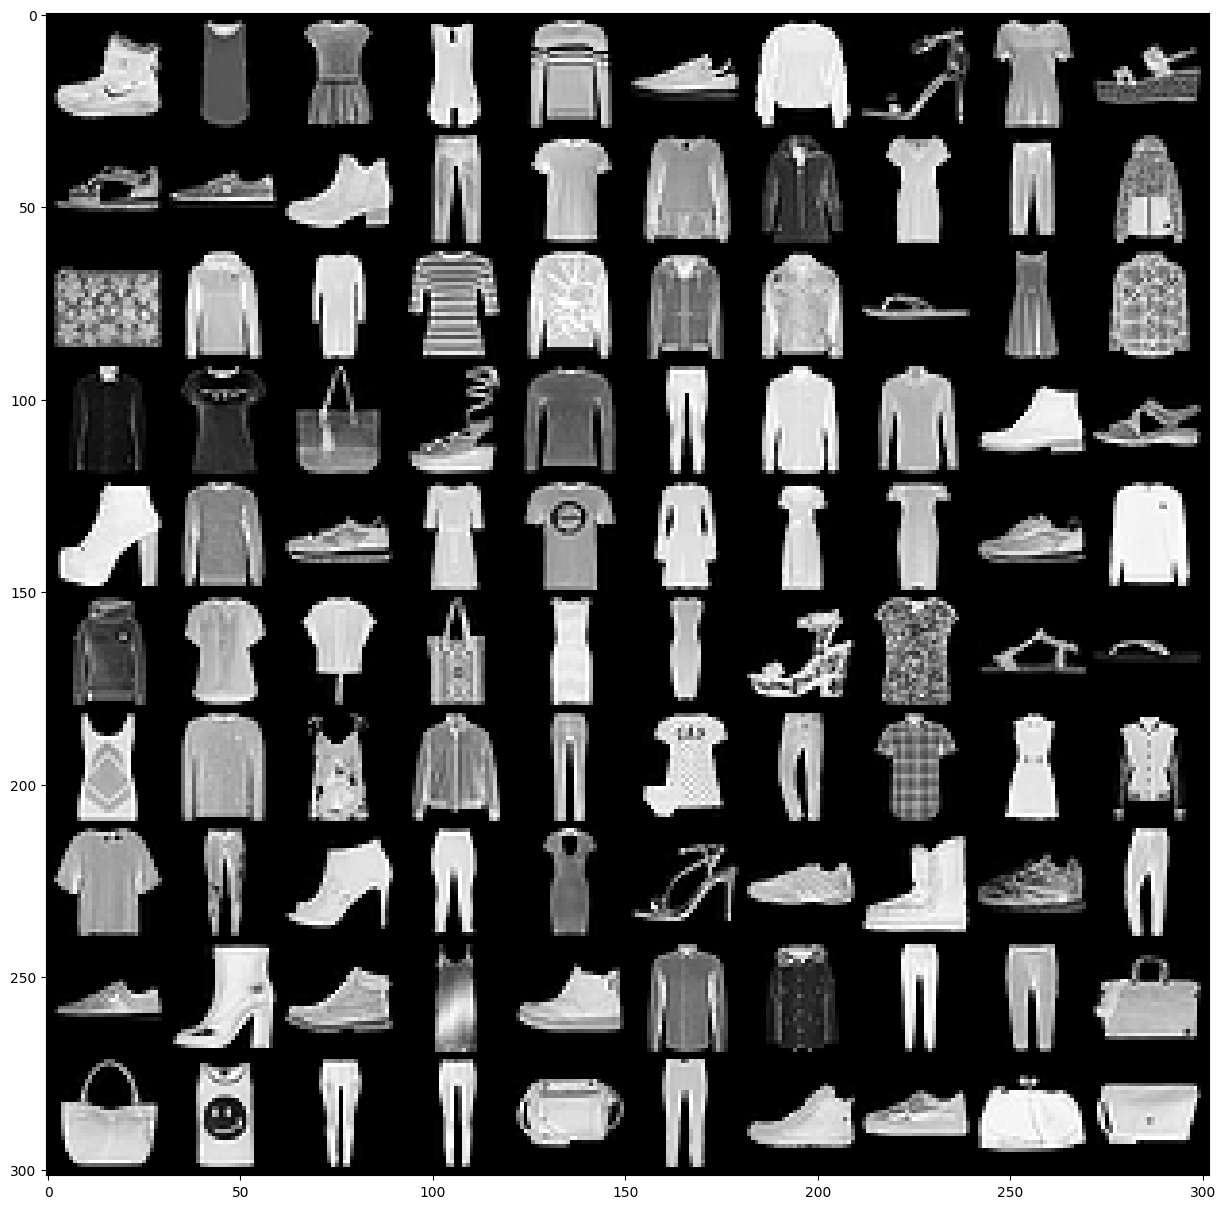

In [7]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

# Show 1 batch of train_set data
batch = next(iter(train_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

---

## Step 3: Building a CNN Model

*   Make a model class
    * It inherits nn.Module class that is a super class for all the neural networks in Pytorch.
* The Neural Net has following layers:
    * Two Sequential layers each consists of following layers-
        * Convolution layer that has kernel size of 3 * 3, padding = 1 (zero_padding) in 1st layer and padding = 0 in second one. Stride of 1 in both layer.
        * Batch Normalization layer.
        * Acitvation function: ReLU.
        * Max Pooling layer with kernel size of 2 * 2 and stride 2.
     * Flatten out the output for dense layer(a.k.a. fully connected layer).
     * 3 Fully connected layer  with different in/out features.
     * 1 Dropout layer that has class probability p = 0.25.
  
     * All the functionaltiy is given in forward method that defines the forward pass of CNN.
     * Our input image is changing in a following way:
        * First Convulation layer : input: 28 \* 28 \* 3, output: 28 \* 28 \* 32
        * First Max Pooling layer : input: 28 \* 28 \* 32, output: 14 \* 14 \* 32
        * Second Conv layer : input : 14 \* 14 \* 32, output: 12 \* 12 \* 64
        * Second Max Pooling layer : 12 \* 12 \* 64, output:  6 \* 6 \* 64
    * Final fully connected layer has 10 output features for 10 types of clothes.

In [8]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

### Set hyperparameters and loss function

*  Creating a object(model in the code)
*  Defining a Loss function. we're using CrossEntropyLoss() here.
*  Using Adam algorithm for optimization purpose.

In [9]:
model = FashionCNN()
print(model)

error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


---

<div class="alert alert-box alert-danger">

## Step 4 (Read-only): Training a network and testing it on test dataset
#### We will not run the training here. The trained model file is given to you under onnx folder

```python

num_epochs = 5

error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        # Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50): 
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1]
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))
```


### Save PyTorch model
After completing the training process, observe the following output:   
* The trained fashion-mnist model is saved at the following location: `onnx/fashion-mnist.pt`.

```python

torch.save(model.state_dict(), 'onnx/fashion-mnist.pt')


```



---

## Step 5: ONNX model generation from a pre-trained pytorch model file

In [10]:
model.load_state_dict(torch.load('onnx/fashion-mnist.pt'))
model.eval()  # Set the model to evaluation mode

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

<div class="alert alert-box alert-success">
<H3>ADD CODE IN BELOW CELL</H3>
Export the model to ONNX format and save to onnx folder 'onnx/fashion-mnist.onnx'<br><b>Reference:  </b>2_pytorch_onnx_re-train.ipynb

In [16]:
## == ADD CODE HERE ==
# define a dummy input with the same shape as the input to the model
dummy_input = torch.randn(1, 1, 28, 28)

# export the model to ONNX format
torch.onnx.export(
    model,                      # model being run
    dummy_input,                # model input (or a tuple for multiple inputs)
    "onnx/fashion-mnist.onnx",  # where to save the model (path)
    verbose=True,               # print out a debug description of the model
    input_names=['input'],      # model's input names
    output_names=['output'],    # model's output names
    export_params=True,         # store the trained parameter weights inside the model file
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},  # Allow dynamic batch size
    opset_version=13
)

print("ONNX model has been successfully exported to 'onnx/fashion-mnist.onnx'")

## ===================

ONNX model has been successfully exported to 'onnx/fashion-mnist.onnx'


### Visualize the input FP32 ONNX model

Generated and adapted using Netron
>Netron is a viewer for neural network, deep learning and machine learning models.

<div class="alert alert-box alert-warning">

<strong>Note</strong> You can right click and download the file './onnx/fashion-mnist.onnx' from the file browser on the left and once the file is dowloaded to your local machine, run the cell below. Then open the model from your local machines' downloads folder.

</div>

In [17]:
from IPython.display import IFrame

notebook_url = "https://netron.app/"

iframe = IFrame(notebook_url, width=800, height=600)

display(iframe)


---

## Step 6: Quantize the Model with Calibration

Quantizing AI models from floating-point to 8-bit integers reduces computational power and the memory footprint required for inference. For model quantization, you can either use [AMD Quark](https://quark.docs.amd.com/latest/index.html) or [Microsoft Olive](https://ryzenai.docs.amd.com/en/latest/olive_quant.html). This example utilizes the AMD Quark quantizer workflow. 
   
This will generate a quantized model using QDQ quant format and UInt8 activation type and Int8 weight type. After the run is completed, the quantized ONNX model `fashion-mnist.qdq.U8S8.onnx` is saved to `onnx/fashion-mnist.qdq.U8S8.onnx`.
    
For more information on representation of quantized ONNX models (e.g., QDQ quant format, UInt8 activation type and Int8 weight type) see [here](https://onnxruntime.ai/docs/performance/model-optimizations/quantization.html#onnx-quantization-representation-format)   
   
The  ```QuantizationConfig``` class is used to configure the quantization parameters to the model. 

#### Full List of Quantization Configuration Features can be [found here](https://quark.docs.amd.com/latest/onnx/appendix_full_quant_config_features.html)


```python
from quark.onnx import ModelQuantizer, PowerOfTwoMethod, QuantType
from quark.onnx.quantization.config.config import Config, QuantizationConfig

quant_config = QuantizationConfig(
    quant_format=quark.onnx.QuantFormat.QDQ,
    calibrate_method=quark.onnx.PowerOfTwoMethod.MinMSE,
    input_nodes=[],
    output_nodes=[],
    op_types_to_quantize=[],
    per_channel=False,
    reduce_range=False,
    activation_type=quark.onnx.QuantType.QInt8,
    weight_type=quark.onnx.QuantType.QInt8,
    nodes_to_quantize=[],
    nodes_to_exclude=[],
    subgraphs_to_exclude=[],
    optimize_model=True,
    use_dynamic_quant=False,
    use_external_data_format=False,
    execution_providers=['CPUExecutionProvider'],
    enable_npu_cnn=False,
    enable_npu_transformer=False,
    convert_fp16_to_fp32=False,
    convert_nchw_to_nhwc=False,
    include_cle=False,
    include_sq=False,
    extra_options={},)
config = Config(global_quant_config=quant_config)

quantizer = ModelQuantizer(config)
quantizer.quantize_model(input_model_path, output_model_path, calibration_data_reader=None)
```



<div class="alert alert-box alert-success">
<H3>ADD CODE IN BELOW CELL</H3>
Pass the 'calibration_set' and 'batch_size' to the Dataloader 

In [18]:
class FmnistCalibrationDataReader(CalibrationDataReader):
    def __init__(self, batch_size: int = 1):
        super().__init__()   
        ## == ADD CODE HERE ==      
        # pass calibration set and batch size to DataLoader
        self.iterator = iter(torch.utils.data.DataLoader(
            calibration_set,
            batch_size=batch_size,
            shuffle=False, 
            drop_last=False
        ))
        ## ===================

    def get_next(self) -> dict:
        try:
            images, labels = next(self.iterator)
            return {"input": images.numpy()}
        except Exception:
            return None

def fmnist_calibration_reader():
    return FmnistCalibrationDataReader()

<div class="alert alert-box alert-success">
<H3>ADD CODE IN BELOW CELL</H3>
<ul>
<li>Set `input_model_path` - the path to the original, unquantized ONNX model.</li>
<li>Set `output_model_path` - the path where the quantized model will be saved</li>
<li>Set quantization configuration</li>
<li>Create an ONNX quantizer and Quantize the ONNX model passing the fmnist_calibration_reader function we defined above</li>
</ul>
<br><b>Reference:  </b>2_pytorch_onnx_re-train.ipynb

In [19]:
# Run the following cell to quantize and save the model:
## == ADD CODE HERE ==
# set the path to the original unquantized ONNX model
input_model_path = "onnx/fashion-mnist.onnx"
# set the path where the quantized model will be saved
output_model_path = "onnx/fashion-mnist.qdq.U8S8.onnx"
# # set the quantization configuration
quant_config = QuantizationConfig(
    quant_format=quark.onnx.QuantFormat.QDQ,
    calibrate_method=quark.onnx.CalibrationMethod.Entropy,
    input_nodes=[],
    output_nodes=[],
    op_types_to_quantize=[],
    per_channel=True,
    reduce_range=False,
    activation_type=quark.onnx.QuantType.QInt8,
    weight_type=quark.onnx.QuantType.QInt8,
    nodes_to_quantize=[],
    nodes_to_exclude=[],
    optimize_model=True,
    use_dynamic_quant=False,
    use_external_data_format=False,
    execution_providers=['CPUExecutionProvider'],
    enable_npu_cnn=False,
    enable_npu_transformer=False,
    convert_fp16_to_fp32=False,
    convert_nchw_to_nhwc=False,
    include_cle=False,
    include_sq=False,
    extra_options={},
)
# # create the global config object
config = Config(global_quant_config=quant_config)
# # create an ONNX quantizer
qantizer = ModelQuantizer(config)
# quantize the ONNX model (positional arguments — no keyword arguments)
quantizer.quantize_model(
    input_model_path,
    output_model_path,
    fmnist_calibration_reader()
)
print("Quantized model has been successfully saved at:", output_model_path)
## ===================


[QUARK-INFO]: The input ONNX model onnx/fashion-mnist.onnx can create InferenceSession successfully


[QUARK_INFO]: Time information:
2025-04-08 13:02:05.719044
[QUARK_INFO]: OS and CPU information:
                                        system --- Windows
                                          node --- aup-strix10-w10
                                       release --- 10
                                       version --- 10.0.26100
                                       machine --- AMD64
                                     processor --- AMD64 Family 26 Model 36 Stepping 0, AuthenticAMD
[QUARK_INFO]: Tools version information:
                                        python --- 3.10.16
                                          onnx --- 1.16.1
                                   onnxruntime --- 1.19.0
                                    quark.onnx --- 0.6.0+dba9ca364
[QUARK_INFO]: Quantized Configuration information:
                                   model_input --- onnx/fashion-mnist.onnx
                                  model_output --- onnx/fashion-mnist.qdq.U8S8.onnx
          


[QUARK-INFO]: Obtained calibration data with 7000 iters

[QUARK-INFO]: Removed initializers from input

[QUARK-INFO]: Simplified model sucessfully

[QUARK-INFO]: Loading model...

[QUARK-INFO]: The input ONNX model C:/Users/AUP/AppData/Local/Temp/vai.simp.m2a1ooat/model_simp.onnx can run inference successfully

[QUARK-INFO]: Start calibration...

[QUARK-INFO]: Start collecting data, runtime depends on your model size and the number of calibration dataset.


Finding optimal threshold for each tensor using 'entropy' algorithm ...
Number of tensors : 11
Number of histogram bins : 128 (The number may increase depends on the data it collects)
Number of quantized bins : 128



[QUARK-INFO]: Finished the calibration of CalibrationMethod.Entropy which costs 6.2s

[QUARK-INFO]: Remove QuantizeLinear & DequantizeLinear on certain operations(such as conv-relu).


The operation types and their corresponding quantities of the input float model is shown in the table below.


┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Op Type              ┃ Float Model                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Conv                 │ 2                                │
│ Relu                 │ 2                                │
│ MaxPool              │ 2                                │
│ Shape                │ 1                                │
│ Constant             │ 3                                │
│ Gather               │ 1                                │
│ Unsqueeze            │ 1                                │
│ Concat               │ 1                                │
│ Reshape              │ 1                                │
│ Gemm                 │ 3                                │
├──────────────────────┼──────────────────────────────────┤
│ Quantized model path │ onnx/fashion-mnist.qdq.U8S8.onnx │
└──────────────────────┴──────────────────────────────────┘

The quantized information for all operation types is shown in the table below.
The discrepancy between the operation types in the quantized model and the float model is due to the application of graph optimization.


┏━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓
┃ Op Type ┃ Activation ┃ Weights ┃ Bias     ┃
┡━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩
│ Conv    │ INT8(2)    │ INT8(2) │ INT32(2) │
│ MaxPool │ INT8(2)    │         │          │
│ Reshape │ INT8(1)    │         │          │
│ Gemm    │ INT8(3)    │ INT8(3) │ INT32(3) │
└─────────┴────────────┴─────────┴──────────┘

Quantized model has been successfully saved at: onnx/fashion-mnist.qdq.U8S8.onnx


After completing the quantization process, observe the following output:

* The quantized fashion-mnist model is saved at the following location in ONNX format: `onnx/fashion-mnist.qdq.U8S8.onnx`.

### Visualize the INT8 quantized ONNX model

Generated and adapted using Netron
>Netron is a viewer for neural network, deep learning and machine learning models.

<div class="alert alert-box alert-warning">

<strong>Note</strong> You can right click and download the file <b>'./onnx/fashion-mnist.qdq.U8S8.onnx'</b> from the file browser on the left and once the file is dowloaded to your local machine, run the cell below. Then open the model from your local machines' downloads folder.

</div>

In [20]:
from IPython.display import IFrame

notebook_url = "https://netron.app/"

iframe = IFrame(notebook_url, width=800, height=600)

display(iframe)


---

## Step 9: Deploy the Model on NPU for Inference with calibration
### Setup xclbin for NPU
Run the next cell to set up the XLNX_VART_FIRMWARE environmental variable to point to the NPU binary. The NPU binary is an AI design that provides up to high performance. multiple such AI streams can be run in parallel on the NPU without any visible loss of performance.<br>
<span style="color:chocolate"><b>Note:</b></span> `XLNX_VART_FIRMWARE` Env variable  is set to the `xclbin` file

In [21]:
# AIE array 
os.environ['XLNX_ENABLE_CACHE'] = '0'
os.environ['XLNX_VART_FIRMWARE']

'C:\\Program Files\\RyzenAI\\1.3.1\\voe-4.0-win_amd64\\xclbins\\strix\\AMD_AIE2P_Nx4_Overlay.xclbin'

### Load quantized ONNX model

Run the following cell to load the provided ONNX quantized model.

<div class="alert alert-box alert-info">

We will use the following pre-trained quantized file:

* The trained quantized fashion-mnist model is saved at the following location: `onnx/fashion-mnist.qdq.U8S8.onnx`
</div>

In [22]:
quantized_model_path1 = r'onnx/fashion-mnist.qdq.U8S8.onnx'
model = onnx.load(quantized_model_path1)

<div class="alert alert-box alert-success">
<H3>ADD CODE IN BELOW CELL</H3>
Deploy model using Vitis AI EP<br>
<br><b>Reference:</b>
<br><a>- https://ryzenai.docs.amd.com/en/latest/modelrun.html</a></br>
- 1_pytorch_onnx_inference-NPU.ipynb

In [23]:
## == ADD CODE HERE ==
# set environment variables for NPU setup
os.environ['XLNX_ENABLE_CACHE'] = '0'
print("XLNX_VART_FIRMWARE:", os.environ.get('XLNX_VART_FIRMWARE'))
# load quantized onnx model from file
quantized_model_path1 = r'onnx/fashion-mnist.qdq.U8S8.onnx'
model = onnx.load(quantized_model_path1)
# define providers and provider options for vitis ai ep
providers = ['VitisAIExecutionProvider']
cache_dir = os.path.join(os.getcwd(), "onnx")
provider_options = [{
    'config_file': 'onnx/vaip_config.json',
    'cacheDir': str(cache_dir),
    'cacheKey': 'mdl_cache_key'
}]
# create onnx runtime inference session using model path
session = ort.InferenceSession(quantized_model_path1, providers=providers, provider_options=provider_options)
print("model deployed on npu successfully")
## ===================

XLNX_VART_FIRMWARE: C:\Program Files\RyzenAI\1.3.1\voe-4.0-win_amd64\xclbins\strix\AMD_AIE2P_Nx4_Overlay.xclbin
model deployed on npu successfully


In [24]:
run_opt = ort.RunOptions()
input_name = session.get_inputs()[0].name
label_name = session.get_outputs()[0].name

### Run Inference on Test set

20 images from the test set are read, classified and  visualized by running the quantized fashion-mnist model on the NPU.

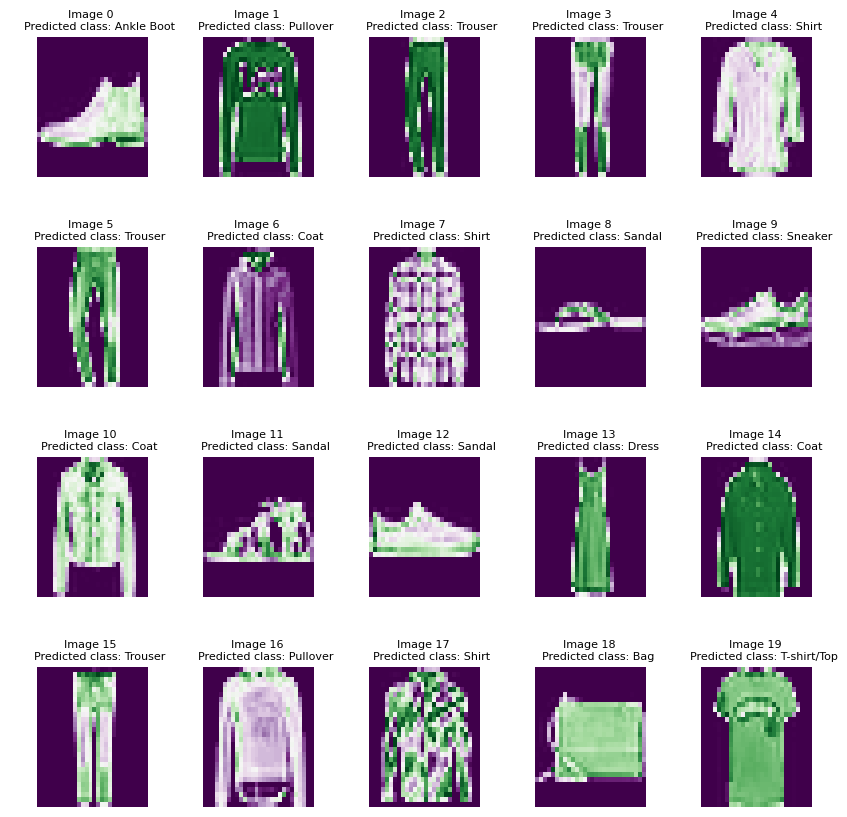

In [25]:
num_images = 20  # Display 20 images
num_cols = 5

fig, axs = plt.subplots(num_images // num_cols, num_cols, figsize=(10, 10))
subplot_size = (8, 8)

cm_predicted_labels = []
cm_actual_labels = []
misclassified_images = []
misclassified_labels = []

for i in range(num_images):
    img, label = test_set[i]
    cm_actual_labels.append(output_label(label))
    img = img[np.newaxis, :]
    
    outputs = session.run(None, {input_name: img.numpy()}, run_options=run_opt)
    logits = torch.tensor(outputs)

    softmax_probs = torch.softmax(logits[0], dim=1)
    predicted_class = torch.argmax(softmax_probs, dim=1).item()
    cm_predicted_labels.append(output_label(predicted_class))

     # Process the outputs
    if (label != predicted_class):
        misclassified_images.append(i)
        misclassified_labels.append(output_label(predicted_class))

    axs[i // num_cols, i % num_cols].imshow(img.numpy().squeeze(), cmap="PRGn")
    axs[i // num_cols, i % num_cols].set_title(f"""Image {i} 
    Predicted class: {output_label(predicted_class)}""", fontsize=8)
    axs[i // num_cols, i % num_cols].axis('off')
    axs[i // num_cols, i % num_cols].set_aspect('auto')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

### Display any Mis-classifications

20 images from the test set are read, classified and  visualized by running the quantized fashion-mnist model on the NPU.

Total misclassified images: 2
[12, 17]


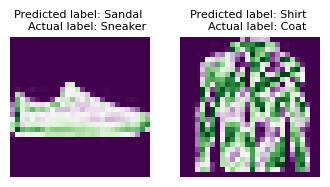

In [26]:
print(f"Total misclassified images: {len(misclassified_images)}")
print(misclassified_images)

show_imlist_mis = []

for i in misclassified_images:
    show_imlist_mis.append(test_set[i][0].squeeze())

varpltsize = len(misclassified_images)

fig = plt.figure(figsize=((1 * 2 * varpltsize), 1 * 2 * varpltsize))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, len(misclassified_images)),  
                 axes_pad=0.3,  # pad between axes in inch.
                 )
cnt=0
for ax, image, label in zip(grid, show_imlist_mis, misclassified_labels):
    ax.axis("off")
    ax.imshow(image,cmap="PRGn")
    ax.set_title(f"""Predicted label: {label} 
    Actual label: {output_label(test_set[misclassified_images[cnt]][1])}""", fontdict={'fontsize':8})
    cnt+=1

plt.show()

<div class="alert alert-box alert-warning">
<H4>Below cells will check the correct working of the notebook.</H4>
<ul>
<li>Accuracy of model on test_set should be above 85%</li>
<li>Reasonable confusion Matrix</li>
<li>36 Nodes should run on the NPU in the vitisai_ep_report.json output JSON file</li>
</ul>
</div>

### Measure accuracy on entire test set

10000 images from the test set are read, classified and we calculate the accuracy of the quantized fashion-mnist model on the NPU.

In [27]:
num_images = 10000 
num_cols = 5

cm_predicted_labels = []
cm_actual_labels = []
misclassified_images = []
misclassified_labels = []

for i in range(num_images):
    img, label = test_set[i]
    cm_actual_labels.append(output_label(label))
    img = img[np.newaxis, :]
    
    outputs = session.run(None, {input_name: img.numpy()}, run_options=run_opt)
    logits = torch.tensor(outputs)

    softmax_probs = torch.softmax(logits[0], dim=1)
    predicted_class = torch.argmax(softmax_probs, dim=1).item()
    cm_predicted_labels.append(output_label(predicted_class))

    # Process the outputs
    if (label != predicted_class):
        misclassified_images.append(i)
        misclassified_labels.append(output_label(predicted_class))

print(f"Total correctly classified images: {10000 - len(misclassified_images)}")
print(f"Total misclassified images: {len(misclassified_images)}")

Total correctly classified images: 8892
Total misclassified images: 1108


<div class="alert alert-box alert-info">
The below accuracy on the test images is calculated for the quantized model run on the NPU.
</div>

In [28]:
print(f" Accuracy of the quantized model for the test set is : {(accuracy_score(cm_actual_labels, cm_predicted_labels)*100):.2f} %")

 Accuracy of the quantized model for the test set is : 88.92 %


### Confusion matrix

The X-axis represents the predicted class and the Y-axis represents the actual class.

The diagonal cells show true positives, they show how many instances of each class were correctly predicted by the model. 
The off-diagonal cells show instances where the predicted class did not match the actual class.

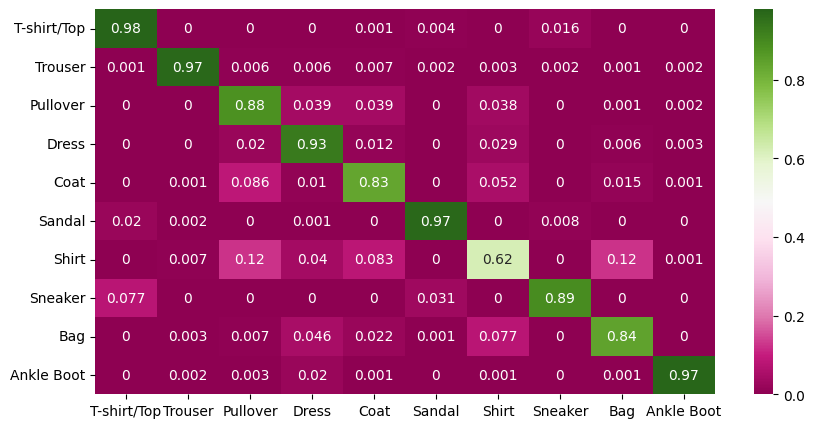

In [29]:
cf_matrix = confusion_matrix(cm_actual_labels, cm_predicted_labels)
df = pd.DataFrame(cf_matrix/np.sum(cf_matrix,axis=1), index = [output_label(i) for i in range(10)], columns=[output_label(i) for i in range(10)])
plt.figure(figsize = (10,5));
sn.heatmap(df, annot=True, cmap="PiYG");

---

### Review Output JSON file and analyze partitioning
Analyze operator partitions between the NPU and CPU.

In [30]:
from IPython.display import JSON
import json

# Load JSON from file
with open("./onnx/mdl_cache_key/vitisai_ep_report.json", "r") as f:
    data = json.load(f)

# Display nicely in Jupyter
JSON(data)


<IPython.core.display.JSON object>

---

## Delete Cache

<div class="alert alert-box alert-info">
<b>Note: Modify the "modelcachekey" folder name incase you are using a different folder name </b>
</div>

In [31]:
cache_path = os.path.join(os.getcwd(), "onnx", "modelcachekey","*")  
files = glob.glob(cache_path)
for f in files:
    try:
        os.remove(f)
    except:
        continue

---